In [146]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from catheter import FNO1d, FNO1d_updated
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


1d X error =  0.0005472336590786564
1d Y error =  0.00038736877123649244


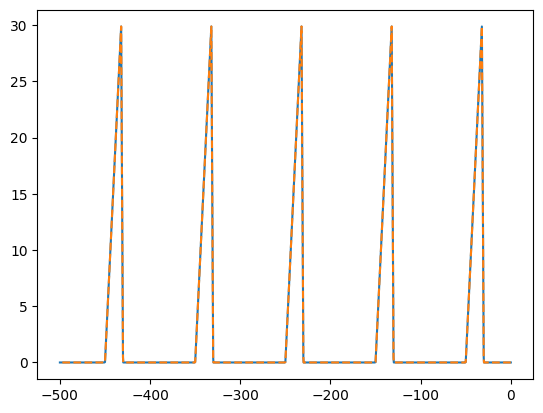

In [148]:
L_x, L_p, x2, x3, h = 500, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


(2001, 300) (7, 300) (2001, 300)
(2001, 100) (2001, 100) (2001, 100)
torch.Size([1, 2001, 3])
[ 22.           5.03923     60.09925132 -30.04962566 -11.64557141
 -15.02815168  29.89950206]
sample =  22.0
min loss =  209298.5229611952 L_p, x2, x3, h =  tensor(60.0993) tensor(-11.6456) tensor(-15.0282) tensor(29.8995)
predicted loss:  294731.001262608
predicted loss updated:  240129.38383512272
-85432.47830141264
-30830.860873927402
0.24987506246876562


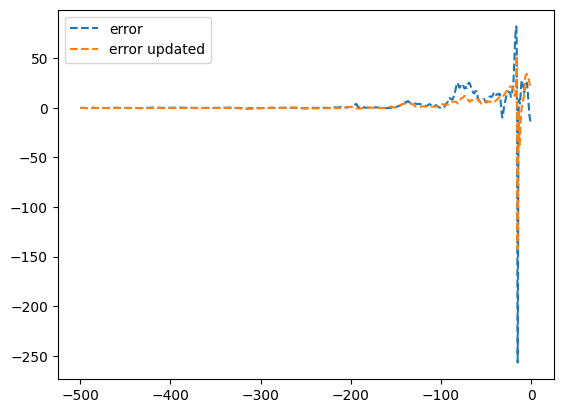

In [149]:
# All data design results
PATH = "/home/wumming/Documents/GNN-PDE/Geo-FNO-catheter/data/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
print(np.load(INPUT_X).shape, np.load(INPUT_para).shape, np.load(OUTPUT).shape)
inputX_raw = np.load(INPUT_X)[:, 0:n_data]
inputY_raw = np.load(INPUT_Y)[:, 0:n_data]
inputPara_raw = np.load(INPUT_para)[:, 0:n_data]
output_raw = np.load(OUTPUT)[:, 0:n_data]


# nx ny
L_x , N_s = 500.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0
print(inputX.shape, inputY.shape, output.shape)


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
model2 = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
print(model2(X_Y).shape)
out2 = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()


print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
print("predicted loss: ", -np.dot(out, xx_mask) * L_x/N_s)
print("predicted loss updated: ", -np.dot(out2, xx_mask) * L_x/N_s)

density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="error")
plt.plot(xx_mask, out2 - density, "--", label="error updated")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(np.dot(out2 - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

-27188.28157945494
-7083.468633391425
0.24987506246876562


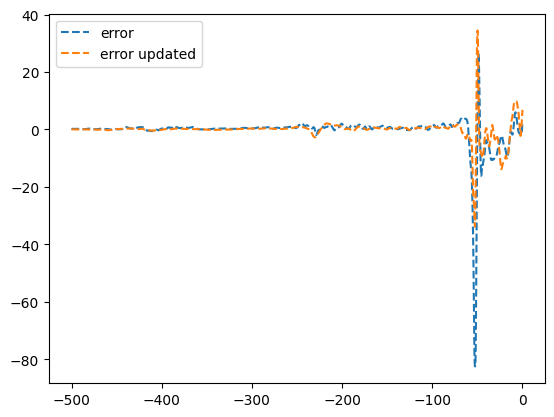

In [150]:
index = 0

sample, uf, L_p, x1, x2, x3, h = inputPara[:, index]
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)

out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
out2 = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()

density = output[:, index]
mesh_X = inputX[:, index]
mesh_Y = inputY[:, index]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="error")
plt.plot(xx_mask, out2 - density, "--", label="error updated")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(np.dot(out2 - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

# BFGS

1336001
initialize :  [ 1.32175584 -0.40546511  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-40.0000, grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
L_p, x1, x2, x3, h  =  100.0 -50.0 -40.000003814697266 -30.0 25.0


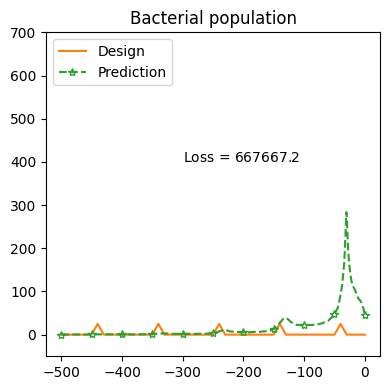

0.0
0 12 0.11198113200043736 loss =  428634.5625 loss_min =  inf
L_p, x1, x2, x3, h  =  76.51350402832031 -38.256752014160156 -23.918087005615234 -19.409564971923828 24.97211456298828


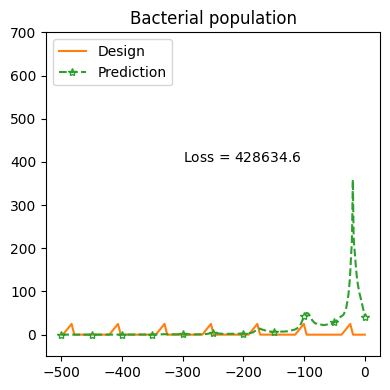

0.0
1 26 0.1429339769983926 loss =  523468.46875 loss_min =  428634.5625
0.0
2 42 0.1579770969983656 loss =  699904.9375 loss_min =  428634.5625
0.0
3 58 0.15031442100007553 loss =  499266.5625 loss_min =  428634.5625
0.0
4 73 0.14954582399877836 loss =  1023831.5 loss_min =  428634.5625
0.0
5 88 0.1480576989997644 loss =  460349.0625 loss_min =  428634.5625
0.0
6 103 0.14004884899986791 loss =  997062.8125 loss_min =  428634.5625
0.0
7 118 0.15282336700147425 loss =  811540.0 loss_min =  428634.5625
0.0
8 132 0.1384657930011599 loss =  336309.34375 loss_min =  428634.5625
L_p, x1, x2, x3, h  =  76.8310546875 -38.41552734375 -13.941913604736328 -20.9440975189209 27.86065101623535


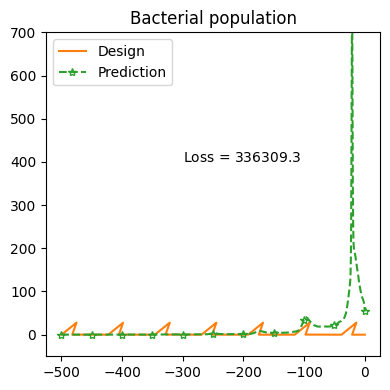

0.0
9 147 0.15156230299908202 loss =  362744.40625 loss_min =  336309.34375
0.0
10 162 0.15125939999961702 loss =  513419.8125 loss_min =  336309.34375
0.0
11 178 0.16635835000124644 loss =  310084.5 loss_min =  336309.34375
L_p, x1, x2, x3, h  =  77.46151733398438 -38.73075866699219 -17.678707122802734 -21.209121704101562 29.016651153564453


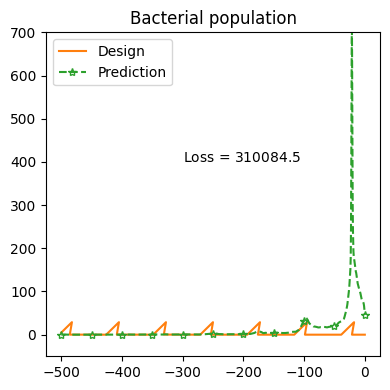

0.0
12 195 0.17337317999954394 loss =  483141.40625 loss_min =  310084.5
0.0
13 204 0.08000632400035101 loss =  229857.671875 loss_min =  310084.5
L_p, x1, x2, x3, h  =  62.425323486328125 -31.212661743164062 -13.861331939697266 -14.584110260009766 29.517620086669922


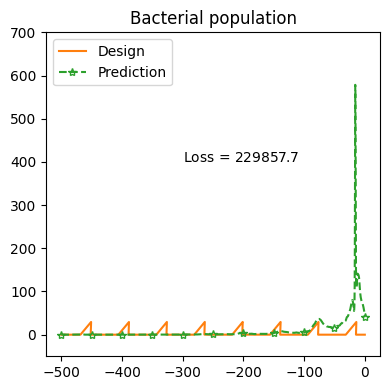

0.0
14 218 0.12850354500005778 loss =  662113.375 loss_min =  229857.671875
0.0
15 235 0.1525438739990932 loss =  287711.71875 loss_min =  229857.671875
0.0
16 251 0.1481144690005749 loss =  339180.25 loss_min =  229857.671875
0.0
17 267 0.16001700799824903 loss =  289877.21875 loss_min =  229857.671875
0.0
18 276 0.08971073000066099 loss =  334169.90625 loss_min =  229857.671875
0.0
19 292 0.14630883099925995 loss =  319344.03125 loss_min =  229857.671875
0.0
20 306 0.12495614999897953 loss =  263352.15625 loss_min =  229857.671875
0.0
21 321 0.1369495779999852 loss =  339479.8125 loss_min =  229857.671875
0.0
22 337 0.1521646500004863 loss =  296814.09375 loss_min =  229857.671875
0.0
23 353 0.14537575199938146 loss =  303948.75 loss_min =  229857.671875
0.0
24 367 0.1260067990006064 loss =  232416.515625 loss_min =  229857.671875
0.0
25 381 0.12703451000015775 loss =  259739.078125 loss_min =  229857.671875


KeyboardInterrupt: 

In [180]:
################################################################
# inverse optimization for 1d
################################################################
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


epochs = 250

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -40.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =  inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

bacteria_pred = []
L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1.0, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)

loss_all = []
theta_min = torch.clone(theta)

def saveplot(theta, out, savefig_name):
    bacteria_pred.append(out)
    L_p, x1, x2, x3, h = transfer(theta)
    mesh = x.detach().cpu().numpy()
    
    current_loss = (-torch.sum(torch.matmul(out, xx_mask))* L_x/N_s).item()
    
    print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
    plt.figure(figsize=(4,4))
    plt.title("Bacterial population")
    plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="C1", label="Design")
    plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "--*", color="C2", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
    
    plt.legend(loc="upper left")
    plt.ylim([-50,700])
    
    plt.text(-300,400,"Loss = "+r"$%3.1f$" %current_loss,\
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1})
    
    
    plt.tight_layout()
    plt.savefig(savefig_name)
    plt.show()
    
plot_id = 0

# first_figure
L_p, x1, x2, x3, h = transfer(theta)  
x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(x).squeeze())
saveplot(theta, out, "movie/design_iter" + str(plot_id).zfill(4) + ".png")
plot_id += 1

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        optimizer.zero_grad()
        L_p, x1, x2, x3, h = transfer(theta)
        
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
        
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out**2, xx_mask))* L_x/N_s
        loss.backward()
        loss_all.append(loss.item())
        return loss
    
#     theta0 = theta
#     optimizer.step(loss_closure)
#     print(torch.norm(theta-theta0).item())
    
    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        out = torch.exp(model(x).squeeze())
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, len(loss_all), t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
 
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            
            
            saveplot(theta, out, "movie/design_iter"+ str(plot_id).zfill(4)+".png")
            plot_id += 1
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta)))

1018883
initialize :  [ 1.32175584 -0.40546511  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-40.0000, grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
L_p, x1, x2, x3, h  =  100.0 -50.0 -40.000003814697266 -30.0 25.0


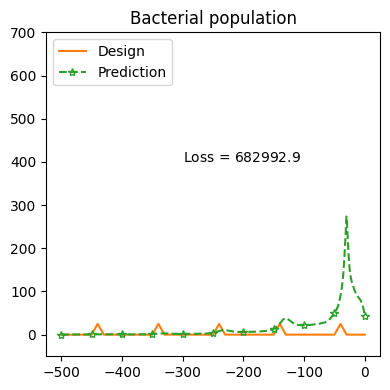

0 11 0.1577610670010472 loss =  662958.25 loss_min =  inf
L_p, x1, x2, x3, h  =  83.07015991210938 -41.53507995605469 -38.540565490722656 -22.927444458007812 25.060440063476562


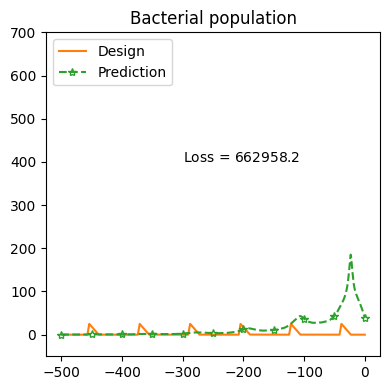

/tmp/ipykernel_10074/3670885998.py:98: RuntimeWarning: divide by zero encountered in log
  theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta))) * 10/(np.log(ep)+1)


1 26 0.20290529600060836 loss =  662958.25 loss_min =  662958.25
2 35 0.11461240700009512 loss =  1713920.0 loss_min =  662958.25
3 48 0.17303516200081503 loss =  527697.6875 loss_min =  662958.25
L_p, x1, x2, x3, h  =  232.19288635253906 -116.09644317626953 -17.184722900390625 -15.954994201660156 22.590408325195312


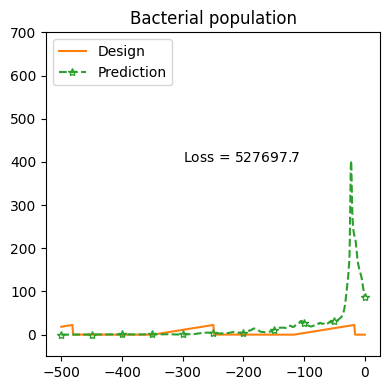

4 56 0.10131187199840497 loss =  2893980.25 loss_min =  527697.6875
5 71 0.19223582800077565 loss =  536393.3125 loss_min =  527697.6875
6 86 0.1960676880007668 loss =  2413517.25 loss_min =  527697.6875
7 94 0.10293881799952942 loss =  2105193.5 loss_min =  527697.6875
8 109 0.18624028700105555 loss =  1290630.125 loss_min =  527697.6875
9 124 0.1926722919997701 loss =  1135275.875 loss_min =  527697.6875
10 139 0.18926391800050624 loss =  865498.0 loss_min =  527697.6875
11 153 0.18503085400152486 loss =  451776.4375 loss_min =  527697.6875
L_p, x1, x2, x3, h  =  234.07228088378906 -117.03614044189453 -37.57666015625 -15.796188354492188 28.47879981994629


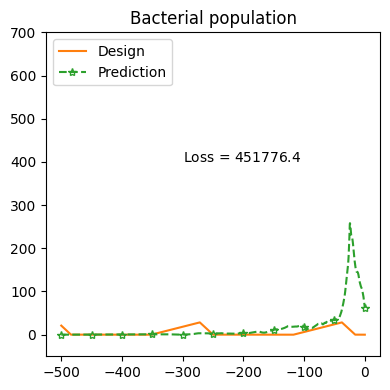

12 168 0.19071051300124964 loss =  527219.75 loss_min =  451776.4375
13 177 0.11316869300026156 loss =  256328.5 loss_min =  451776.4375
L_p, x1, x2, x3, h  =  65.50009155273438 -32.75004577636719 -9.648460388183594 -3.1922731399536133 29.80487632751465


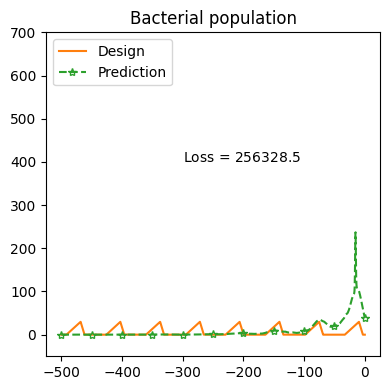

14 193 0.20196370699886756 loss =  942201.0625 loss_min =  256328.5
15 213 0.2524268810011563 loss =  1287967.0 loss_min =  256328.5
16 231 0.22926017500140006 loss =  535469.25 loss_min =  256328.5
17 250 0.2459633849994134 loss =  489758.375 loss_min =  256328.5
18 268 0.22796113200092805 loss =  608758.1875 loss_min =  256328.5
19 288 0.25848875299925567 loss =  1304700.125 loss_min =  256328.5
20 305 0.2242425340009504 loss =  292390.0 loss_min =  256328.5
21 323 0.22438383600092493 loss =  562168.625 loss_min =  256328.5
22 342 0.24128805799955444 loss =  556388.4375 loss_min =  256328.5
23 361 0.23866329200063774 loss =  473600.90625 loss_min =  256328.5
24 378 0.21631174399954034 loss =  259024.953125 loss_min =  256328.5
25 395 0.21801015100027143 loss =  282135.59375 loss_min =  256328.5
26 411 0.21091442899887625 loss =  893431.875 loss_min =  256328.5
27 429 0.23770148099902144 loss =  1578061.75 loss_min =  256328.5
28 446 0.21239346400034265 loss =  282081.34375 loss_min =

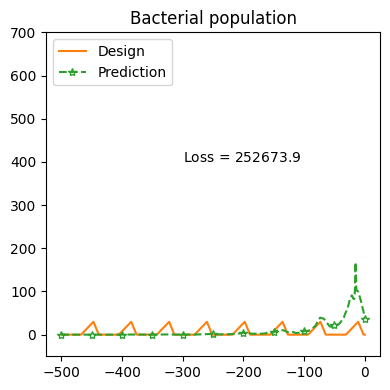

34 553 0.23288996200062684 loss =  685564.1875 loss_min =  252673.9375
35 569 0.20671312599915836 loss =  755825.9375 loss_min =  252673.9375
36 586 0.21932465499958198 loss =  563859.5 loss_min =  252673.9375
37 603 0.21499279999989085 loss =  290837.21875 loss_min =  252673.9375
38 619 0.1997185839991289 loss =  261945.578125 loss_min =  252673.9375
39 635 0.2067085960006807 loss =  289839.375 loss_min =  252673.9375
40 651 0.2038975079994998 loss =  451162.125 loss_min =  252673.9375
41 669 0.2271325439996872 loss =  861889.5625 loss_min =  252673.9375
42 678 0.11459581700000854 loss =  277506.875 loss_min =  252673.9375
43 694 0.20268140500047593 loss =  245710.28125 loss_min =  252673.9375
L_p, x1, x2, x3, h  =  60.200218200683594 -30.100109100341797 -13.565799713134766 -6.0697736740112305 29.839534759521484


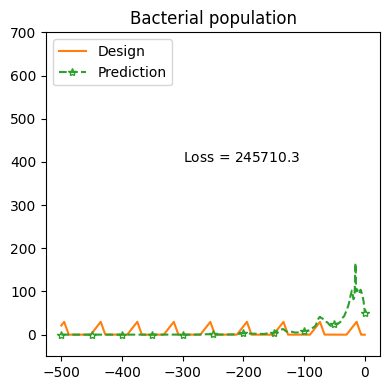

44 713 0.2445286220008711 loss =  313486.75 loss_min =  245710.28125
45 730 0.21484785999928135 loss =  738954.3125 loss_min =  245710.28125
46 747 0.21360404600090988 loss =  843659.9375 loss_min =  245710.28125
47 765 0.23560696100139467 loss =  507648.375 loss_min =  245710.28125
48 781 0.2046910660010326 loss =  830205.0 loss_min =  245710.28125
49 798 0.21442038599889202 loss =  255223.171875 loss_min =  245710.28125
50 807 0.11291243000050599 loss =  274253.375 loss_min =  245710.28125
51 823 0.2077442070003599 loss =  257213.796875 loss_min =  245710.28125
52 832 0.1136603989998548 loss =  262151.625 loss_min =  245710.28125
53 847 0.19468947499990463 loss =  264297.4375 loss_min =  245710.28125
54 863 0.20497228900057962 loss =  251192.875 loss_min =  245710.28125
55 880 0.2160569530005887 loss =  292518.9375 loss_min =  245710.28125
56 897 0.21559524700023758 loss =  304924.375 loss_min =  245710.28125
57 914 0.21970217800117098 loss =  377496.5 loss_min =  245710.28125
58 931

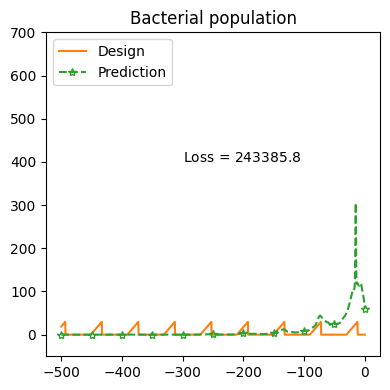

66 1065 0.21562150799945812 loss =  419421.875 loss_min =  243385.8125
67 1074 0.11812415399981546 loss =  246772.59375 loss_min =  243385.8125
68 1089 0.18993681600113632 loss =  245982.375 loss_min =  243385.8125
69 1105 0.203354893001233 loss =  255272.921875 loss_min =  243385.8125
70 1120 0.18707178699878568 loss =  274015.0625 loss_min =  243385.8125
71 1137 0.21781296100016334 loss =  372663.4375 loss_min =  243385.8125
72 1154 0.21620979399995122 loss =  312165.90625 loss_min =  243385.8125
73 1169 0.19653705400014587 loss =  250840.25 loss_min =  243385.8125
74 1185 0.20483310700001311 loss =  284722.03125 loss_min =  243385.8125
75 1202 0.2228491509995365 loss =  504952.46875 loss_min =  243385.8125
76 1218 0.20478615799947875 loss =  262988.5 loss_min =  243385.8125
77 1233 0.19471539499863866 loss =  255168.578125 loss_min =  243385.8125
78 1249 0.20400949999930162 loss =  307470.9375 loss_min =  243385.8125
79 1264 0.19262931299999764 loss =  282895.28125 loss_min =  24338

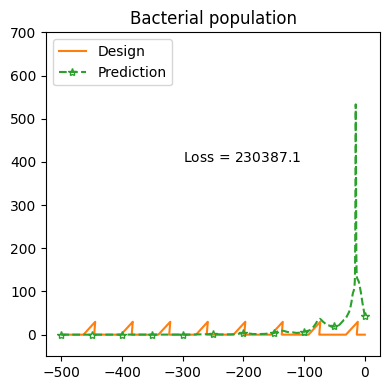

87 1395 0.20285750800030655 loss =  249799.4375 loss_min =  230387.0625
88 1411 0.204375744000572 loss =  273344.65625 loss_min =  230387.0625
89 1429 0.23503392599923245 loss =  265265.71875 loss_min =  230387.0625
90 1448 0.24092502699932083 loss =  674548.3125 loss_min =  230387.0625
91 1466 0.22429773699877842 loss =  368637.1875 loss_min =  230387.0625
92 1483 0.22029191599904152 loss =  234841.765625 loss_min =  230387.0625
93 1501 0.2327561140009493 loss =  233290.703125 loss_min =  230387.0625
94 1510 0.11397974100145802 loss =  276965.28125 loss_min =  230387.0625
95 1526 0.20623683300073026 loss =  243190.09375 loss_min =  230387.0625
96 1543 0.21684089100017445 loss =  260522.890625 loss_min =  230387.0625
97 1559 0.20971300900055212 loss =  254998.28125 loss_min =  230387.0625
98 1574 0.19322768100028043 loss =  256300.8125 loss_min =  230387.0625
99 1591 0.21653058800075087 loss =  369346.09375 loss_min =  230387.0625
100 1606 0.1942286299999978 loss =  274548.90625 loss_m

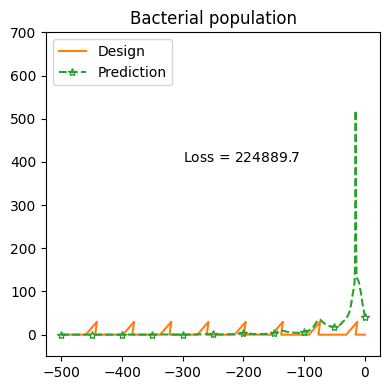

124 1907 0.15266947700001765 loss =  951750.25 loss_min =  224889.734375
125 1913 0.07520782700157724 loss =  250101.40625 loss_min =  224889.734375
126 1920 0.08837723199940228 loss =  330229.875 loss_min =  224889.734375
127 1927 0.09113606000028085 loss =  235685.078125 loss_min =  224889.734375
128 1935 0.10472816900073667 loss =  275983.6875 loss_min =  224889.734375
129 1941 0.07580756400056998 loss =  251467.71875 loss_min =  224889.734375
130 1948 0.08973898600015673 loss =  260128.03125 loss_min =  224889.734375
131 1961 0.16329473599944322 loss =  688940.25 loss_min =  224889.734375
132 1970 0.11534546699840575 loss =  264155.4375 loss_min =  224889.734375
133 1983 0.16335812600118516 loss =  360693.71875 loss_min =  224889.734375
134 1996 0.1637972609987628 loss =  445315.3125 loss_min =  224889.734375
135 2002 0.07629827699929592 loss =  245193.1875 loss_min =  224889.734375
136 2009 0.08686745500017423 loss =  251477.359375 loss_min =  224889.734375
137 2016 0.090564343001

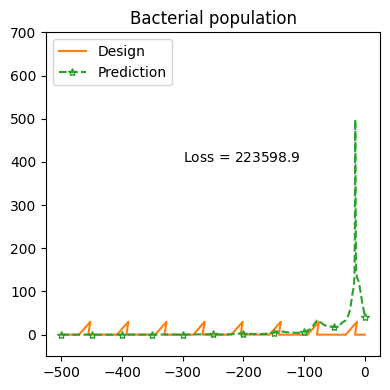

231 2559 0.067070793998937 loss =  377620.34375 loss_min =  223598.9375
232 2563 0.05207442199935031 loss =  234599.4375 loss_min =  223598.9375
233 2569 0.07659086099920387 loss =  247942.34375 loss_min =  223598.9375
234 2573 0.05231883299893525 loss =  247721.140625 loss_min =  223598.9375
235 2579 0.07899214600001869 loss =  237518.15625 loss_min =  223598.9375
236 2586 0.08846882200123218 loss =  333810.21875 loss_min =  223598.9375
237 2593 0.09035458200014546 loss =  297925.84375 loss_min =  223598.9375
238 2601 0.10626075499931176 loss =  272706.6875 loss_min =  223598.9375
239 2609 0.10773631899974134 loss =  336618.59375 loss_min =  223598.9375
240 2616 0.09385026699965238 loss =  318862.40625 loss_min =  223598.9375
241 2623 0.09538573299869313 loss =  252888.796875 loss_min =  223598.9375
242 2630 0.09400502899916319 loss =  241276.125 loss_min =  223598.9375
243 2637 0.09715809100089245 loss =  264764.5 loss_min =  223598.9375
244 2646 0.11952566999934788 loss =  923179.5 

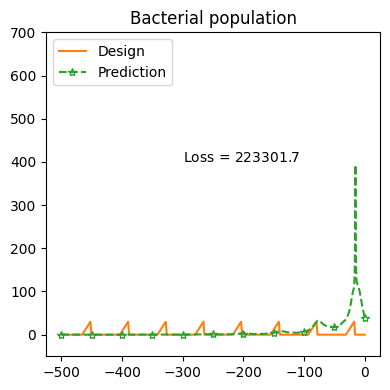

In [13]:
################################################################
# inverse optimization for 1d
################################################################
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device)
print(count_params(model))


epochs = 250

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):


# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -40.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =  inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

bacteria_pred = []
L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)

loss_all = []
loss_all_min = []
theta_min = torch.clone(theta)

plot_id = 0

# first_figure
L_p, x1, x2, x3, h = transfer(theta)  
x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(x)).mean(-1).squeeze()
saveplot(theta, out, "movie/design_iter" + str(plot_id).zfill(4) + ".png")
plot_id += 1

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        
        L_p, x1, x2, x3, h = transfer(theta)
        
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
        optimizer.zero_grad()
        out = torch.exp(model(x)).mean(-1).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        loss_all.append(loss.item())
        loss_all_min.append(loss_min)
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        out = torch.exp(model(x)).mean(-1).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, len(loss_all), t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
 
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            
            
            saveplot(theta, out, "movie/design_iter"+ str(plot_id).zfill(4)+".png")
            plot_id += 1
            
        theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta))) * 10/(np.log(ep)+1)

In [191]:
# theta0_tensor  = torch.tensor(theta0).cuda()

class MLP_theta(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP_theta, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, mid_channels, 1)
        self.mlp3 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        x = F.gelu(x)
        x = self.mlp3(x)
        return x.squeeze() + theta0_tensor

In [192]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1
        
#     print('l', l)
    # l is a scalar

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
#     print('d', d.shape)
#     plt.plot(d.detach().cpu().numpy())
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape).to(device), torch.zeros(d.shape).to(device)
    ind = (d < l0)
#     print('ind', ind)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
#     L_s = L_p_s*n_periods + 10
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s).to(device) * L_s
    
    # TODO do not compute gradient for floor
#     period_arr = torch.floor(d_arr / L_p_s).detach()
    period_arr = torch.floor(d_arr / L_p_s)
    d_arr = d_arr - period_arr * L_p_s
    
#     plt.plot(period_arr.detach().cpu().numpy())
    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
#     xx = d_arr
#     yy = d_arr
        
    xx = xx - period_arr*L_p
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
#     X_Y = torch.stack([xx, yy], dim=-1).reshape(1,-1,2)
    return X_Y, xx, yy

1018883
67332
initialize :  [ 1.32175584 -0.40546511  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-40.0000, grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
L_p, x1, x2, x3, h  =  100.0 -50.0 -40.000003814697266 -30.0 25.0


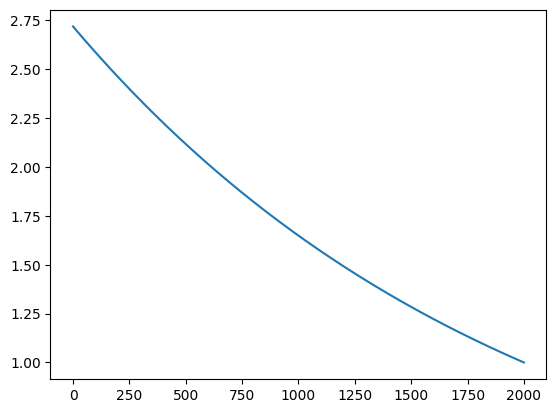

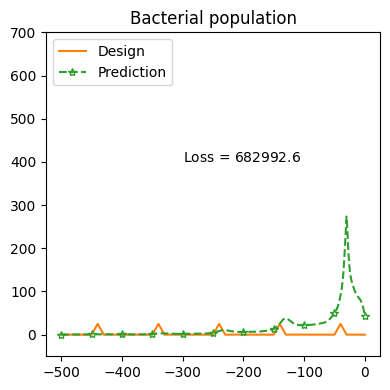

0 1 0.017479801001172746 loss =  561016.875 loss_min =  inf
1 2 0.018460440000126255 loss =  467259.5 loss_min =  561016.875
2 3 0.015873705999183585 loss =  422579.125 loss_min =  467259.5
3 4 0.0175849820006988 loss =  405260.375 loss_min =  422579.125
4 5 0.017658852999375085 loss =  401771.9375 loss_min =  405260.375
5 6 0.015609722999215592 loss =  399685.71875 loss_min =  401771.9375
6 7 0.015623953000613255 loss =  399645.375 loss_min =  399685.71875
7 8 0.015256269000019529 loss =  411092.96875 loss_min =  399645.375
8 9 0.01684834600018803 loss =  410548.03125 loss_min =  399645.375
9 10 0.016910885999095626 loss =  426262.15625 loss_min =  399645.375
10 11 0.016020056998968357 loss =  446847.03125 loss_min =  399645.375
11 12 0.01680267499978072 loss =  468005.4375 loss_min =  399645.375
12 13 0.018699854001170024 loss =  484068.15625 loss_min =  399645.375
13 14 0.021864223999727983 loss =  497378.21875 loss_min =  399645.375
14 15 0.01825199799895927 loss =  507940.71875 lo

123 124 0.015921127000183333 loss =  430447.78125 loss_min =  324791.78125
124 125 0.01730732999931206 loss =  430281.40625 loss_min =  324791.78125
125 126 0.014169019001201377 loss =  430087.03125 loss_min =  324791.78125
126 127 0.01632731999961834 loss =  429887.03125 loss_min =  324791.78125
127 128 0.016179629001271678 loss =  429679.0 loss_min =  324791.78125
128 129 0.01794233700093173 loss =  429471.15625 loss_min =  324791.78125
129 130 0.01698020599906158 loss =  429284.84375 loss_min =  324791.78125
130 131 0.014665654000054928 loss =  429115.6875 loss_min =  324791.78125
131 132 0.016660063998642727 loss =  428974.0 loss_min =  324791.78125
132 133 0.01812131800033967 loss =  428865.0 loss_min =  324791.78125
133 134 0.018510023000999354 loss =  428782.28125 loss_min =  324791.78125
134 135 0.02022784899963881 loss =  428745.25 loss_min =  324791.78125
135 136 0.018178747999627376 loss =  428747.71875 loss_min =  324791.78125
136 137 0.017640182999457465 loss =  428787.718

KeyboardInterrupt: 

In [198]:
################################################################
# inverse optimization for 1d
################################################################
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

model = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device).cuda()
print(count_params(model))

model_theta = MLP_theta(in_channels=1, out_channels=4, mid_channels=256).cuda()
print(count_params(model_theta))

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):


# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -40.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =  inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)



theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

bacteria_pred = []
L_x = 500
N_s = 2001
xx_mask = -(torch.linspace(1.0, 0, N_s) * (L_x)).to(device)
xx_mask_train = torch.exp(torch.linspace(1.0, 0, N_s).to(device))

# plt.plot(xx_mask.cpu().numpy())
plt.plot(xx_mask_train.cpu().numpy())

epochs = 500
# optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1, line_search_fn="strong_wolfe")
optimizer = torch.optim.Adam([theta], lr=0.2, weight_decay=1e-1)
# optimizer = torch.optim.Adam(model_theta.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

loss_min = torch.tensor(np.inf)
target = torch.tensor(-200000.0).cuda()
theta_input = torch.tensor(0.0).reshape(1,1,1).cuda()

loss_all = []
loss_all_min = []
theta_min = torch.clone(theta)

plot_id = 0

# first_figure
L_p, x1, x2, x3, h = transfer(theta)  
x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(x)).mean(-1).squeeze()
saveplot(theta, out, "movie/design_iter" + str(plot_id).zfill(4) + ".png")
plot_id += 1


for ep in range(epochs):
#     optimizer = torch.optim.Adam([theta], lr=0.1, weight_decay=0)
    
    t1 = default_timer()

#     with torch.autograd.set_detect_anomaly(True):
        
    optimizer.zero_grad()

#     theta = model_theta(theta_input)
    L_p, x1, x2, x3, h = transfer(theta)
    x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)


    out = torch.exp(model(x)).mean(-1).squeeze()
    loss = torch.sum(torch.matmul(out**2, -xx_mask))* L_x/N_s
#     loss = torch.sum(out*xx_mask)
#     loss = loss**2
#     loss_f = torch.nn.functional.mse_loss(loss, target)
    loss.backward()
    
    loss_all.append(loss.item())
    loss_all_min.append(loss_min)

    
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
 
    with torch.no_grad():
        if ep%1==0:

            L_p, x1, x2, x3, h = transfer(theta)
            x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
            out = torch.exp(model(x)).mean(-1).squeeze()
            loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
#             loss = torch.sum(torch.matmul(out, xx_mask_train))* L_x/N_s
            print(ep, len(loss_all), t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)

            if loss < loss_min:

                theta_min = torch.clone(theta)
                loss_min = loss
            
            
#             saveplot(theta, out, "movie/design_iter"+ str(plot_id).zfill(4)+".png")
#             plot_id += 1
            
#         print(scheduler.get_lr())
#         theta = theta_min + 0.1*torch.normal(mean=0.0, std=torch.ones(len(theta))) * scheduler.get_lr()[0]
#         theta = theta/2 + theta_min/2
#         theta +=  0.1 * torch.randn(4) * scheduler.get_lr()[0]

1018883
initialize :  [ 1.32175584 -0.40546511  1.79175947  0.        ]
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-40.0000, grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
L_p, x1, x2, x3, h  =  100.0 -50.0 -40.000003814697266 -30.0 25.0


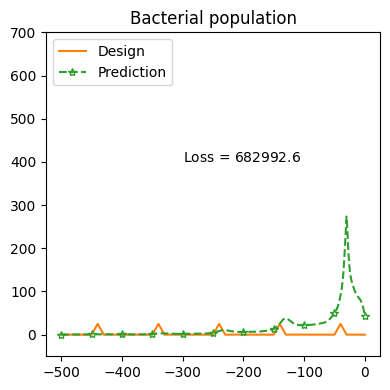

0 67 1.1936409520003508 loss =  1843506.625 loss_min =  inf
1 80 0.23842532800063054 loss =  1843506.625 loss_min =  1843506.625
2 93 0.23256611400029215 loss =  1843506.625 loss_min =  1843506.625
3 106 0.22151644699988537 loss =  1843506.625 loss_min =  1843506.625
4 119 0.226650458000222 loss =  1843506.625 loss_min =  1843506.625
5 132 0.23893854299967643 loss =  1843506.625 loss_min =  1843506.625
6 145 0.237658972000645 loss =  1843506.625 loss_min =  1843506.625
7 158 0.2208259030003319 loss =  1843506.625 loss_min =  1843506.625
8 171 0.2321222430000489 loss =  1843506.625 loss_min =  1843506.625
9 184 0.22731623600066087 loss =  1843506.625 loss_min =  1843506.625
10 197 0.24254521900002146 loss =  1843506.625 loss_min =  1843506.625
11 210 0.22080552999977954 loss =  1843506.625 loss_min =  1843506.625
12 223 0.2448268130001452 loss =  1843506.625 loss_min =  1843506.625
13 236 0.23939701500057708 loss =  1843506.625 loss_min =  1843506.625


KeyboardInterrupt: 

In [145]:
################################################################
# inverse optimization for 1d
################################################################
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device)
print(count_params(model))


epochs = 250

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):


# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -40.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =  inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

bacteria_pred = []
L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

max_iter = 100

optimizer = torch.optim.LBFGS([theta], max_iter=max_iter, lr=1, line_search_fn="strong_wolfe")

loss_min = torch.tensor(np.inf)

loss_all = []
loss_all_min = []
theta_min = torch.clone(theta)

plot_id = 0

# first_figure
L_p, x1, x2, x3, h = transfer(theta)  
x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(x)).mean(-1).squeeze()
saveplot(theta, out, "movie/design_iter" + str(plot_id).zfill(4) + ".png")
plot_id += 1

for ep in range(epochs):
    t1 = default_timer()
    def loss_closure():
        optimizer.zero_grad()
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        
        out = torch.exp(model(x)).mean(-1).squeeze()
        loss = torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        loss.backward()
        loss_all.append(loss.item())
        loss_all_min.append(loss_min)
        return loss
    
    
    optimizer.step(loss_closure)

    t2 = default_timer()
 
    if ep%1==0:
        
        L_p, x1, x2, x3, h = transfer(theta)
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        out = torch.exp(model(x)).mean(-1).squeeze()
        loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
        print(ep, len(loss_all), t2 - t1,  "loss = ", loss.item(), "loss_min = ", loss_min.item(),)
 
        if loss < loss_min:
            
            theta_min = torch.clone(theta)
            loss_min = loss
            
            
#             saveplot(theta, out, "movie/design_iter"+ str(plot_id).zfill(4)+".png")
#             plot_id += 1
            
#         theta = theta_min + torch.normal(mean=0.0, std=torch.ones(len(theta))) * 10/(np.log(ep)+1)

In [ ]:
fig = plt.figure(figsize=(8,3))
plt.semilogy(loss_all, "-", markersize=1)
minind = np.array(loss_all).argmin()
plt.scatter(minind, loss_all[minind], color="red", s=2)
fig.savefig("optimization-loss.pdf")

loss_all_min_cpu = [l.cpu().detach().numpy() for l in loss_all_min]
fig = plt.figure(figsize=(8,3))
plt.semilogy(loss_all_min_cpu, "-", markersize=1)
plt.ylim(200000, 300000)

minind = np.array(loss_all).argmin()
plt.scatter(minind, loss_all[minind], color="red", s=2)
fig.savefig("optimization-loss.pdf")

1570

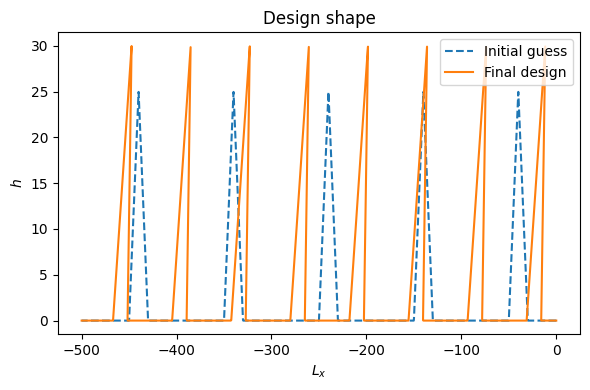

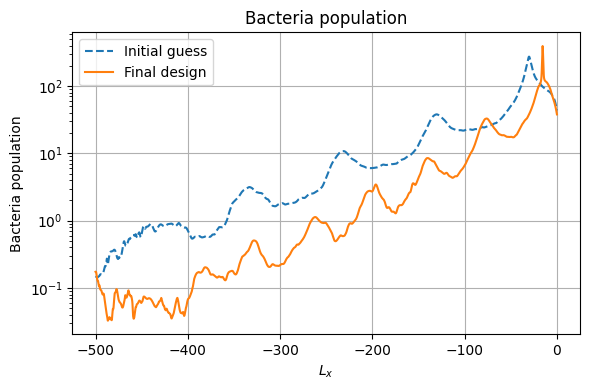

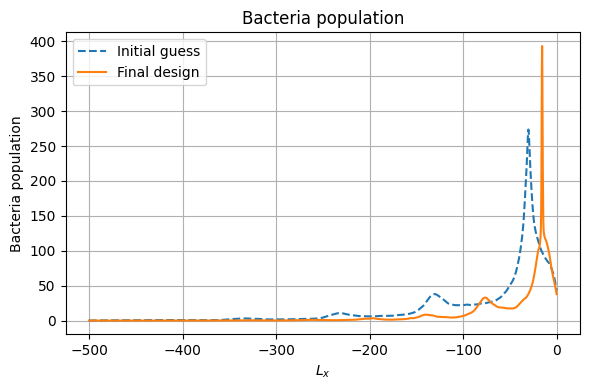

In [9]:
# Draw initial guess and final designs 

L_x, L_p, x2, x3, h = 500, 100.0, -40.0, -30.0, 25.0
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 4))
plt.plot(X0, Y0, "--", label="Initial guess")
L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.plot(X0, Y0, label="Final design")
plt.legend()
plt.title("Design shape")
plt.ylabel("$h$")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("design.png")


xx_mask = np.linspace(1.0, 0, N_s) * (-L_x)
#######################################################################
plt.figure(figsize=(6, 4))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), "--", label="Initial guess")
plt.semilogy(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), label="Final design")
plt.legend()
plt.title("Bacteria population")
plt.grid("on")
plt.ylabel("Bacteria population")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("bacteria_population_semilogy.png")


#######################################################################
plt.figure(figsize=(6, 4))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), "--", label="Initial guess")
plt.plot(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), label="Final design")
plt.legend()
plt.title("Bacteria population")
plt.grid("on")
plt.ylabel("Bacteria population")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("bacteria_population.png")

fno_loss =  224575.9375 ref_loss =  -0.0


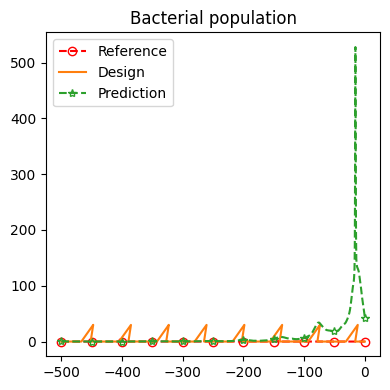

In [10]:
import glob
# Design validation

train_data_folder = "data"
t = 9


N_s, L_x = 2001, 500
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

samples = [0]
x_mesh, y_mesh = np.zeros((len(samples), N_s)), np.zeros((len(samples), N_s))
density_1d_data_all = np.zeros((len(samples), N_s, 3))
density_1d_data = np.zeros((len(samples), N_s))
L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
# L_p, x1, x2, x3, h = 62.32211685180664, -31.16105842590332, -11.533348083496094, -16.148033142089844, 29.966632843017578

for i in range(len(samples)):
    
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/tri*")
    for file_name in file_names:
        
        print(file_name)
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)

    plt.figure(figsize=(4,4))
    plt.plot(xx,  density_1d_data[i, :], "--o", color="red", markevery=len(xx_mask)//10, fillstyle='none', label="Reference")
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C1", label="Design")
    
    ref_loss = -np.sum(np.matmul(density_1d_data[i, :], xx))* L_x/N_s
    

    x, XC, YC = catheter_mesh_1d_total_length(L_x, torch.tensor(L_p), torch.tensor(x2), torch.tensor(x3), h, N_s)
    out = torch.exp(model(x)).mean(-1).squeeze()
    fno_loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    print("fno_loss = ", fno_loss.item(), "ref_loss = ", ref_loss)
        
    plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "--*", color="C2", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
    plt.legend()
    plt.title("Bacterial population")
    plt.tight_layout()
    plt.savefig("Design_tri.pdf")



# Plot 

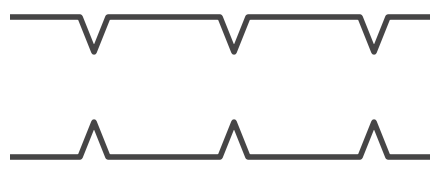

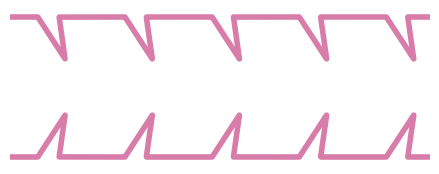

In [25]:
# Draw initial guess and final designs 

L_x, L_p, x2, x3, h = 500, 100.0, -40.0, -30.0, 25.0
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 2))
plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
plt.plot(X0, Y0, color="#464546", linewidth=4.0)
plt.axis('off'),
plt.xlim([-300, 0])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("initial_guess.pdf")

L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 2))
plt.plot(X0, 100-Y0, color="#D87CA9", linewidth=4.0)
plt.plot(X0, Y0, color="#D87CA9", linewidth=4.0)
plt.axis('off'),
plt.xlim([-300, 0])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("final_guess.pdf")
# plt.title("Design shape")
# plt.ylabel("$h$")
# plt.xlabel("$L_x$")
# plt.savefig("design.png")




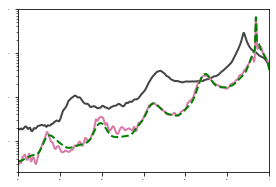

In [37]:
xx_mask = np.linspace(1.0, 0, N_s) * (-L_x)
#######################################################################
plt.figure(figsize=(4.5, 3))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), color="#464546", linewidth=2.0, label="initial design")
plt.semilogy(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), color="#D87CA9", linewidth=2.0, label="optimized design")
plt.semilogy(xx_mask, density_1d_data[i, :], "--",  color="green", linewidth=2.0)

plt.xlim([-300, 0])
plt.ylim([0.2, 1e3])
#plt.grid(linestyle='--', linewidth=0.5)


# plt.legend(loc = "upper center",bbox_to_anchor=(0.5,1.15),ncol=2)
# plt.tight_layout()
plt.tick_params(labelsize=0) 
# plt.yticks(labelsize=0) 
plt.savefig("bacteria_population_semilogy.pdf")




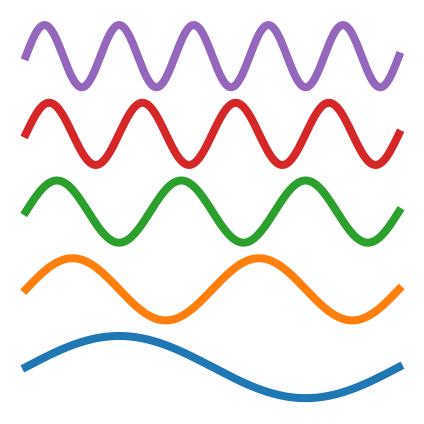

In [54]:
# Draw Fourier basis functions

xx = np.linspace(0, 1, 1001)

plt.figure(figsize=(6, 6))
dy = 2.5
shift = 0
for i in range(5):
    plt.plot(xx, np.sin(2*np.pi*(i+1)*xx)+shift*dy, color="C"+str(i),  linewidth=8.0)
    shift += 1.0
#     plt.plot(xx, np.cos(2*np.pi*(2*i+2)*xx)+shift*dy,   linewidth=4.0)
#     shift += 1.0
plt.axis('off'),
# ax = plt.gca()
# # ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("Fourier_basis_functions.pdf")



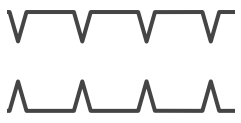

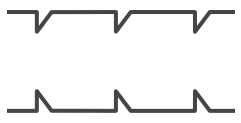

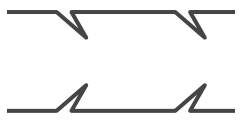

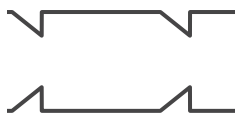

In [5]:
L_x = 500
L_ps = [65, 80, 120, 150]
x2s = [-L_ps[0]/2+ 8.5, -L_ps[1]/2, -L_ps[2]/2 + 30.0, -L_ps[3]/2 + 30.0]
x3s = [-L_ps[0]/2 + 17.0, -L_ps[1]/2 + 15, -L_ps[2]/2 + 15.0, -L_ps[3]/2 + 30.0]

hs = [29.9, 20, 26, 24]
for i in range(4):
    L_p = L_ps[i] 
    x1 = -L_p/2.0
    x2, x3 = x2s[i], x3s[i]
    h = hs[i]

    N_s = 2001
    X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    plt.figure(figsize=(6, 2))
    plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
    plt.plot(X0, Y0, color="#464546", linewidth=4.0)
    plt.axis('off'),
    plt.xlim([-230, 0])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.savefig("design_data_"+str(i)+".pdf")

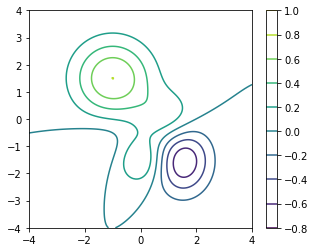

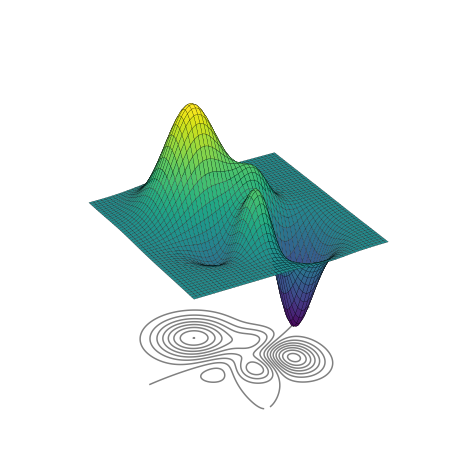

In [131]:
def Gaussian_helper(x, m, C):
    return np.exp(-0.5*np.dot(x - m , np.linalg.solve(C,x - m)))
    
def Gaussian(X, Y, m, C):
    nx, ny = X.shape
    Z = np.zeros((nx, ny))
    for ix in range(nx):
        for iy in range(ny):
            Z[ix, iy] = Gaussian_helper(np.array([X[ix, iy], Y[ix, iy]]), m, C)
    return Z

nx, ny = 200, 200
xx = np.linspace(-4, 4, nx)
yy = np.linspace(-4, 4, ny)
X, Y = np.meshgrid(xx ,yy)


Z = np.zeros((nx, ny))
Z += 0.8*Gaussian(X, Y, np.array([-1.0, 1.5]), np.array([[1.0, 0.0], [0.0, 1.0]]))
Z += 0.4*Gaussian(X, Y, np.array([1.0, 0.0]), np.array([[0.5, 0.0], [0.0, 0.5]]))
Z += 0.5*Gaussian(X, Y, np.array([0.0, -1.5]), np.array([[0.4, 0.0], [0.0, 0.4]]))
Z += -0.2*Gaussian(X, Y, np.array([-1.2, -1.0]), np.array([[0.8, 0.0], [0.0, 0.5]]))
Z += -0.8*Gaussian(X, Y, np.array([1.5, -1.5]), np.array([[0.5, 0.0], [0.0, 0.8]]))

plt.figure(figsize=(5,4))
# plt.pcolormesh(X, Y, Z)
plt.contour(X, Y, Z)
plt.colorbar()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.2, linestyles="solid", edgecolors='k', rstride=4, cstride=4)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.contour(X, Y, Z, 15, colors="grey", linestyles="solid", offset=-1.0)
# ax.set_xlabel("x")
ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(30, -120)
fig.savefig("optimization.pdf")
# fig = plt.figure(figsize=(4,3))
# ax = fig.add_subplot(111, projection='3d')

# # Z += np.sin(np.pi*X)*np.sin(np.pi*Y)
# ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.1, rstride=1, cstride=1)
# # # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
# ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", offset=-0.5)

# ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
# # ax.view_init(30, 30)
# plt.show()


# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# fig.axes.get_zaxis().set_visible(False)
# 
# # ax.set_xticks([0, -30, -60])
# ax.tick_params(axis='x', which='major', pad=-4)
# ax.set_xlabel(r"$x_2$", labelpad=-5)
# # ax.set_yticks([0, -8, -16])
# ax.tick_params(axis='y', which='major', pad=-4)

# ax.set_ylabel(r"$x_3$", labelpad=-5)
# # ax.set_zticks([3e5, 6e5, 9e5])
# ax.tick_params(axis='z', which='major', pad=-4)

# # ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
# fig.tight_layout()
# fig.savefig("landscape-1.pdf")

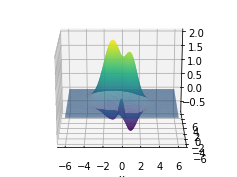

In [87]:

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.0, rstride=1, cstride=1)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
# ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", offset=-0.5)
ax.set_xlabel("x")
# ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(20, -90)
plt.show()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'lw'
  # Remove the CWD from sys.path while we load stuff.
/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


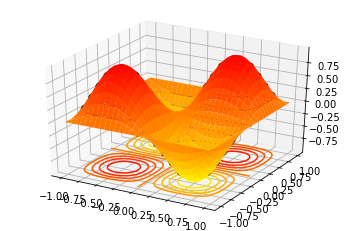

In [90]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
ax.plot_surface(X, Y, Z, cmap="autumn_r", lw=0.5, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  


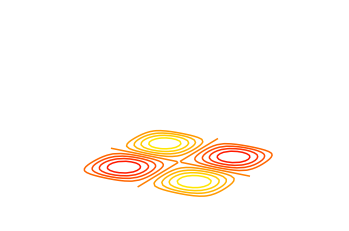

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
# ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.0, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.set_axis_off()
plt.show()